### Volatility Modeling, Master Mathematics for Finance and Data (MFD), Ecole des Ponts ParisTech and Université Gustave Eiffel, 2022-23
# Computing assignment

### Due Date: 1:30 PM Monday, February 27
You should turn in the notebook at the Educnet website.

Please comment your code properly.

Before you turn in the notebook, press the "Run all cells" button in the toolbar, and make sure all the calculation results and graphs are produced correctly in a reasonable time frame, and then save the notebook.

In [776]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
plt.rc('figure', figsize=(6, 5.5))
plt.rc('axes', grid=True, xmargin=0, ymargin=0, autolimit_mode='round_numbers')

# 1. Conditional Expection and Least Square Regression

Let $X$ and $Y$ be two random variables. The conditional expectation $\mathbb{E}\left[Y|X\right]$ is a function $f^{\ast}$ of $X$ that best approximates $Y$ in the least square sense, i.e.,

$$\mathbb{E}\left[Y|X\right]=f^{\ast}(X)\quad\text{and}\quad\mathbb{E}\left[\left|Y-f^{\ast}(X)\right|^2\right]\leq\mathbb{E}\left[\left|Y-f(X)\right|^2\right]\text{ for any function }f\text{ of }X$$

Let us define the random variables $X$ and $Y$ by
$$
g(x) = x \frac{1 + x}{1 + x^2}, \qquad X \sim \mathcal{N}(0, 1), \quad Y = g(X) + \varepsilon
$$
where $\varepsilon \sim \mathcal{N}(0, 1/16)$ is independent of $X$.

Note that $\mathbb{E}\left[\left.Y\right|X\right] = \mathbb{E}\left[\left.g(X)+\varepsilon\right|X\right] = g(X)+\mathbb{E}\left[\left.\varepsilon\right|X\right] = g(X)$.

Text(0, 0.5, 'Y')

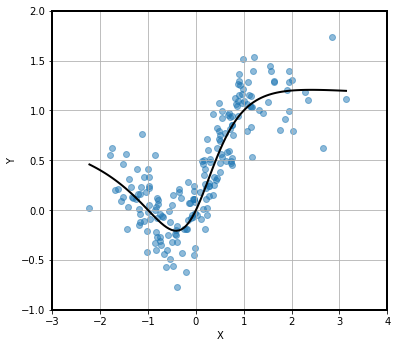

In [777]:
# Plot a random sample of the joint distribution and the 
# theoretical conditional expectation of Y wrt X.
np.random.seed(80)
def g(x):
    return x*(1+x)/(1+x**2)

n = 200
sigma = 0.25
X = np.random.randn(n)
Y = g(X) + sigma * np.random.randn(n)

fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
x = np.linspace(X.min(), X.max(), 101)
ax.plot(x, g(x), 'k', linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')

## Parametric regression

The conditional expection $\mathbb{E}\left[\left.Y\right|X\right]$ is approximated by a linear combination of a set of given <em>basis</em> functions $\{f_i(X)\}_{0\leq i\leq n}$, i.e.,

$$\mathbb{E}\left[Y|X\right]\approx \beta_0^*f_0(X)+\cdots+\beta_n^*f_n(X)$$

where 

$$\mathbb{E}\left[\left(Y-\beta_0^*f_0(X)-\cdots-\beta_n^*f_n(X)\right)^2\right] = \min_{\beta_1,\ldots,\beta_n}\mathbb{E}\left[\left(Y-\beta_0f_0(X)-\cdots-\beta_nf_n(X)\right)^2\right]$$

Given $N$ observations $\left((x_1,y_1),\ldots,(x_N, y_N)\right)$ of $X$ and $Y$, one finds the optimal parameters $\beta_i$ by solving the least square problem $\min_\beta\|A\beta-y\|_2$, where

$$A=\begin{bmatrix}f_0(x_1) & \cdots & f_n(x_1)\\ \vdots & \ddots & \vdots \\ f_0(x_N) & \cdots & f_n(x_N)\end{bmatrix}\quad
\text{and}\quad y=\begin{bmatrix}y_1\\ \vdots \\ y_N\end{bmatrix}$$

The numpy routine <strong>numpy.linalg.lstsq</strong> can be used to solve such linear least square problems.

### Polynomials

The basis functions are taken to be power functions $f_i(X)=X^{i}$, that is $\mathbb{E}\left[Y|X\right]$ is a polynomial of $X$. The numpy routine <strong>numpy.polyfit</strong> is a convenient way to obtain the least square polynomial fit.

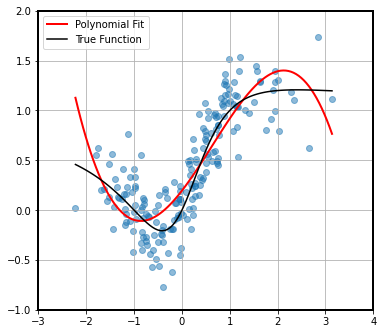

In [778]:
# Fit a polynomial of degree 3 to the sample points (X, Y)
p = np.polyfit(X, Y, deg=3)
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, np.polyval(p, x), 'r', lw=2, label='Polynomial Fit')
ax.plot(x, g(x), 'k', label='True Function')
ax.legend(loc=0)

### Piecewise Linear Regression

In [779]:
def pwlin_basis(xknots):
    """Basis that represent a piecewise linear function with given knots"""
    fs = [lambda x: np.ones_like(x, dtype=float), lambda x: x-xknots[0]]
    fs.extend([lambda x, a=xknots[i]: np.maximum(x-a, 0) for i in range(len(xknots))])
    return fs

def pwlin_fit(xdata, ydata, xknots):
    """Fit a piecewise linear function with xknots to xdata and ydata"""
    fs = pwlin_basis(xknots)
    A = np.column_stack([f(xdata) for f in fs])
    ps = np.linalg.lstsq(A, ydata, rcond=None)[0]
    return ps, fs

Text(0, 0.5, 'Y')

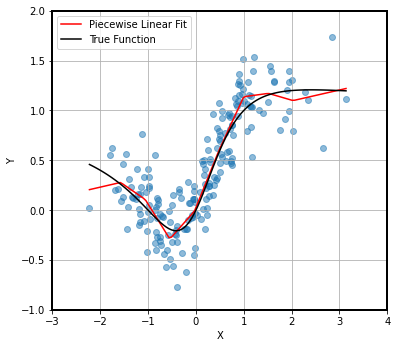

In [780]:
xknots = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 8)
ps, fs = pwlin_fit(X, Y, xknots)
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, sum([f(x)*p for (f, p) in zip(fs, ps)]), 'r', label='Piecewise Linear Fit')
ax.plot(x, g(x), 'k', label='True Function')
ax.legend(loc=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')

## Nonparametric regression

### Nadaraya-Watson Kernel regression (Local Weighted Average)

Here, no parametric form is assumed for $\mathbb{E}[Y|X]$. Instead, local averages of $Y$ values are computed, given the value of $X$:

$$\mathbb{E}\left[Y|X=x\right]\approx\frac{\sum_{i=1}^NK_h(x-x_i)y_i}{\sum_{i=1}^NK_h(x-x_i)}$$
where $K$ is a kernel function and $K_h(x)=K(x/h)/h$, $h$ is the <em>bandwidth</em>. $K_h$ approximates the Dirac mass at zero.

### Local Linear Regression

The locally weighted linear regression solves a separate weighted least squares problem at each target point $x$,

$$\hat{\alpha},\hat{\beta} = \text{argmin}_{\alpha,\beta}\sum_{i=1}^NK_h(x-x_i)\left[y_i-\alpha-\beta x_i\right]^2$$

which yields an estimate $\hat{\alpha}+\hat{\beta}x$. Note that $\hat{\alpha}$ and $\hat{\beta}$ depend on $x$. The locally-weighted averages can be badly biased on the boundaries. This bias
can be removed by local linear regression to the first order.

<b>Note.</b> To speed up, we often perform the local regression only at a selection of points and then use interpolation/extrapolation to evaluate at other target points.

In [781]:
# Non-parametric regression function

def gauss_kern(x):
    """Gaussian kernel function"""
    return np.exp(-x**2/2)

def kern_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Nadaraya-Watson Kernel Regression (Locally weighted average)

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    weights = kern((xdata[:, np.newaxis] - x) / bandwidth)
    return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)


def ll_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Local Linear Regression

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    
    def func(xx):
        weights = np.sqrt(kern((xdata-xx)/bandwidth))
        b = ydata*weights
        A = np.column_stack((np.ones_like(xdata), xdata-xx))*weights[:, np.newaxis]
        yy, _ = np.linalg.lstsq(A, b, rcond=None)[0]
        return yy
    
    return np.vectorize(func)(x)

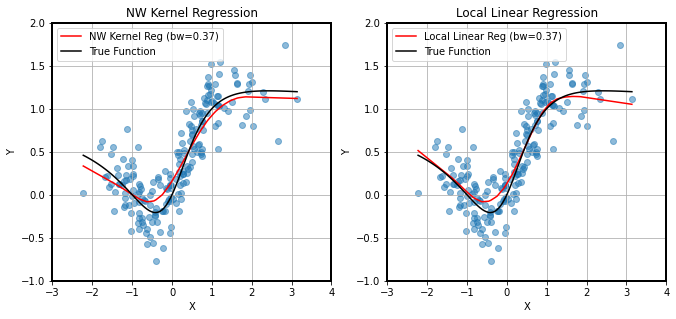

In [782]:
fig, axs = plt.subplots(1,2, figsize=(11, 4.75))
bw_silverman = (4/(3*len(X)))**0.2*np.std(X)
# NW Kernel Regression
xknots0 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)
yknots0 = kern_reg(xknots0, X, Y, bw_silverman, gauss_kern)
f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
axs[0].plot(x, f0(x), color='r', label='NW Kernel Reg (bw={:.2f})'.format(bw_silverman))
axs[0].set_title('NW Kernel Regression')
# Local Linear Regression
xknots1 = xknots0
yknots1 = ll_reg(xknots1, X, Y, bw_silverman, gauss_kern)
f1 = interp1d(xknots1, yknots1, kind='linear', fill_value='extrapolate')
axs[1].plot(x, f1(x), color='r', label='Local Linear Reg (bw={:.2f})'.format(bw_silverman))
axs[1].set_title('Local Linear Regression')
for ax in axs:
    ax.scatter(X, Y, alpha=0.5)
    ax.plot(x, g(x), 'k', label='True Function')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc=0)

## Questions

<b>(a)</b>. (Parametric regression) In general, increasing the number of basis functions in the regression gives us more flexibility to better fit the data. However, having too many parameters in the model oftentimes leads to overfitting, which usually has poor predictive performance and is over-sensitive to small noise in the data. To observe the overftting phenomenon, in polynomial fit, try to use different degrees of the polynomials; in piecewise-linear regression, try to use different numbers of knots. Then reproduce the scatter plot with fitted regression function. Compare and comment on the results.

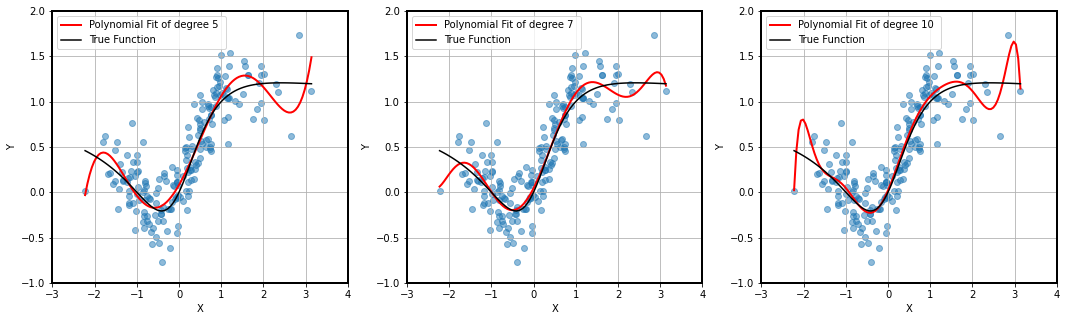

In [783]:
#Polynomial fit of degree 5, 10, 15 to the sample points (X, Y)
fig, axs = plt.subplots(1,3, figsize=(18, 5))

deg = [5, 7, 10]
for i in range(3):
    p = np.polyfit(X, Y, deg[i])
    axs[i].plot(x, np.polyval(p, x), 'r', lw=2, label='Polynomial Fit of degree {:.0f} '.format(deg[i]))

for ax in axs:
    ax.scatter(X, Y, alpha=0.5)
    ax.plot(x, g(x), 'k', label='True Function')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc=0)


- **Comment:** we can see that when we take higher polynomial degrees the polynomial fit overfit the data. However if the degree (in our case) is higher then 10, the polynomial fit is very far from the real data

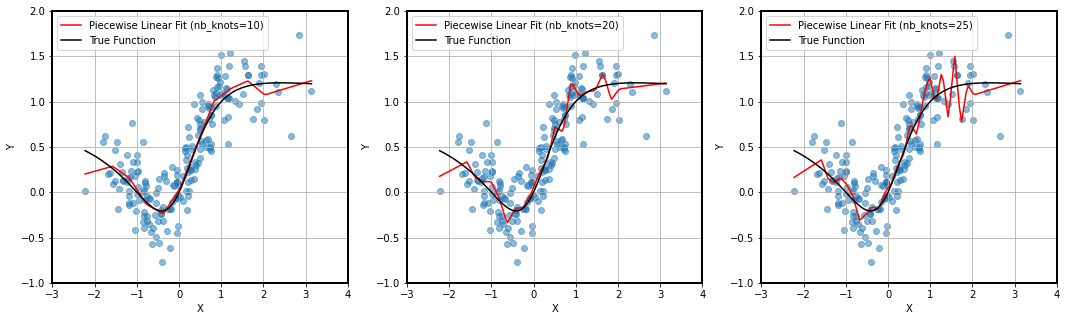

In [784]:
# Piecewise linear regression with 10, 20, 30 as number of knots
fig, axs = plt.subplots(1,3, figsize=(18, 5))
nb_knots = [10, 20, 25]
for i in range(3):
    xknots = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), nb_knots[i])
    ps, fs = pwlin_fit(X, Y, xknots)
    axs[i].plot(x, sum([f(x)*p for (f, p) in zip(fs, ps)]), 'r', label='Piecewise Linear Fit (nb_knots={:.0f})'.format(nb_knots[i]))

for ax in axs:
    ax.scatter(X, Y, alpha=0.5)
    ax.plot(x, g(x), 'k', label='True Function')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc=0)

- **Comment:** we can see that as we increase the number of knots the piecewise linear regression fit overfit the data.

<b>(b)</b>. For nonparametric regression,
<ul>
<li>Try different bandwidth values in the kernel regression. Reproduce the scatter plot with fitted regression function. Compare and comment on the results. For what values of the bandwidth do we observe overfitting? For what values of the bandwidth do we observe a poor fit?</li>
<li>Try to use different kernels, for example
$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere.}$$
Which has more impact: the bandwidth $h$ or the kernel $K$?
</ul>

In [785]:
# Different values of bandwidth
bw = [0.1, 0.3, 1., 2.]

In [786]:
colors = ['firebrick', 'navy', 'purple', 'blue']

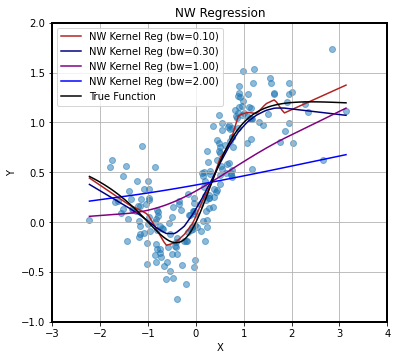

In [787]:
# NW Kernel Regression
xknots0 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)
fct = [] 

for i in range(4):
    yknots0 = kern_reg(xknots0, X, Y, bw[i], gauss_kern)
    f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
    plt.plot(x, f0(x), color = colors[i], label = 'NW Kernel Reg (bw={:.2f})'.format(bw[i]))


plt.scatter(X, Y, alpha=0.5)
plt.plot(x, g(x), 'k', label='True Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('NW Regression')
plt.legend(loc=0)



- **Comment:** We can see that the Nadaraya-Watson Kernel Regression depends on the bandwidth. For big values of bandwidth (compared to the silverman bandwidth) there is underfitting. For small values there is overfitting 

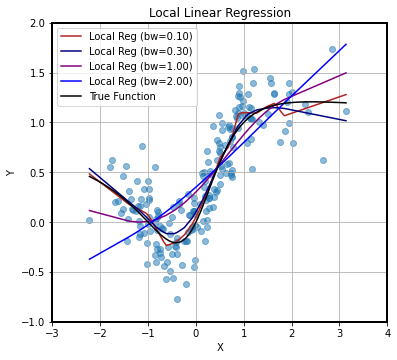

In [788]:
# Local Linear Regression
xknots1 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)
fct1 = [] 


for i in range(4):
    yknots1 = ll_reg(xknots1, X, Y, bw[i], gauss_kern)
    f1 = interp1d(xknots1, yknots1, kind='linear', fill_value='extrapolate')
    plt.plot(x, f1(x), color = colors[i], label = 'Local Reg (bw={:.2f})'.format(bw[i]))


plt.scatter(X, Y, alpha=0.5)
plt.plot(x, g(x), 'k', label='True Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Local Linear Regression')
plt.legend(loc=0)

**Comment:** We make the same remarks as in the Nadaraya-Watson Kernel Regression

In [789]:
# Quartic
def Kern_1(x):
    return ((x + 1.) ** 2) * ((1. - x)**2) * ((x <= 1.) & (x >= -1.))

# Tricube
def Kern_2(x):
    return ((1 - np.abs(x[i])**3)**3) * ((x <= 1.) & (x >= -1.))

# Epanechnikov
def Kern_3(x):
    return (3/4 * (1 - x[i]**2)) * ((x <= 1.) & (x >= -1.))

In [790]:
Kernels = [Kern_1, Kern_2, Kern_3]

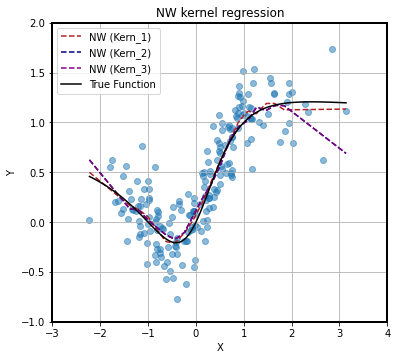

In [791]:
# NW kernel regression
xknots0 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)


for i in range(3):
    yknots0 = kern_reg(xknots0, X, Y, bw_silverman, Kernels[i])
    f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
    plt.plot(x, f0(x),'--', color = colors[i], label = 'NW (Kern_{:.0f})'.format(i+1))

plt.scatter(X, Y, alpha=0.5)
plt.plot(x, g(x), 'k', label='True Function')
plt.title('NW kernel regression')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc=0)

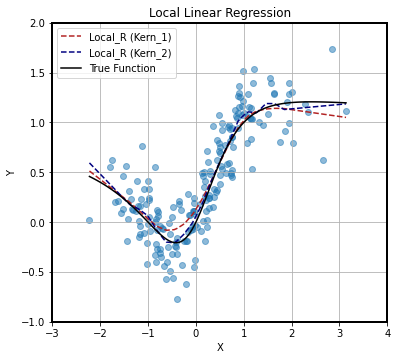

In [792]:
# Local Linear Regression
xknots1 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)

Kernels = [gauss_kern, Kern_1]
for i in range(2):
    yknots1 = ll_reg(xknots1, X, Y, bw_silverman, Kernels[i])
    f1 = interp1d(xknots1, yknots1, kind='linear', fill_value='extrapolate')
    plt.plot(x, f1(x),'--', color = colors[i], label = 'Local_R (Kern_{:.0f})'.format(i+1))
    
plt.scatter(X, Y, alpha=0.5)
plt.plot(x, g(x), 'k', label='True Function')
plt.title('Local Linear Regression')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc=0)

- **Comment:** The bandwidth has more impact than the kernel

# 2. The Particle Method and Smile Calibration

<!--<h3 style="color:deepskyblue">The Particle Method and Smile Calibration</h3>-->

Consider the stochastic local volatility (SLV) model

$$
\begin{array}{l}
dS_t = a_t l(t, S_t) S_t dW^{(1)}_t\\
a_t=\sigma_0 e^{Y_t}\quad\text{where}\quad d Y_t = -\kappa Y_tdt+\gamma dW^{(2)}_t\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

The numerical values for the model parameters are
- $T = 1$.
- $S_0 = 100$.
- $\sigma_0 = 15\%$.
- $Y_0 = 0$.
- $\rho = -50\%$.
- $\gamma = 50\%$.
- $\kappa = 1$.

The goal is to find a leverage function $l(t, S)$ so that this model matches the market prices of vanilla options. For the sake of simplicity, we assume that the market implied volatility surface is flat $\sigma_{\textrm{Market}} \equiv 15\%$. In that case, we also have $\sigma_{\textrm{loc}}(t,S) \equiv 15\%$.

Below we describe a Monte Carlo simulation scheme for the SLV model.

First we discretize the interval $(0,T)$ into subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$, and set $\Delta t_i=t_i-t_{i-1}$. 

The Ornstein-Uhlenbeck process $Y$ is explicitly solvable:
\begin{equation}
Y_{t_i}=e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\int_{t_{i-1}}^{t_i}\gamma e^{-\kappa\left(t_i-s\right)}dW_s^{(2)}.
\end{equation}

Therefore for given $Y_{t_{i-1}}$, $Y_{t_i}$ is a Gaussian variable with 
\begin{equation}\tag{1}
\mathbb{E}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=e^{-\kappa\Delta t_i}Y_{t_{i-1}},\quad
\text{var}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=\frac{\gamma^2}{2\kappa}\left(1-e^{-2\kappa\Delta t_i}\right)
\end{equation}

so that paths of $Y$ can be simulated exactly.

To simualte the spot process $S$, we use the Euler scheme:
$$\log S_{t_i}-\log S_{t_{i-1}}=-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i+\sigma_0 e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\int_{t_{i-1}}^{t_i}dW^{(1)}_t$$

Thus for given $S_{t_{i-1}}$ and $Y_{t_{i-1}}$, $\log S_{t_i}$ and $Y_{t_i}$ are jointly Gaussian variables with

\begin{equation}\tag{2}
\mathbb{E}\left[\left.\log S_{t_i}\right\vert S_{t_{i-1}},Y_{t_{i-1}}\right]=\log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}\Delta t_i,\quad\text{Var}\left[\left.\log S_{t_i}\right\vert S_{i_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i
\end{equation}

\begin{equation}\tag{3}
\text{Cov}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0 e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\frac{\gamma\rho}{\kappa}\left(1-e^{-\kappa\Delta t_i}\right)
\quad\text{or}\quad
\text{Corr}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\rho\sqrt{\frac{2(1-e^{-\kappa\Delta t_i})}{\kappa\Delta t_i(1+e^{-\kappa\Delta t_i})}}
\end{equation}

Over the time interval $[t_{i-1}, t_i]$, we can advance $\log S$ and $Y$ by generating Gaussian variables $\log S_{t_i}$ and $Y_{t_i}$ using equations (1)-(3). That is,

\begin{align}
\log S_{t_i} &= \log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i+\sigma_0e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\sqrt{\Delta t_i}\left(\sqrt{1-\bar{\rho}^2}Z_1+\bar{\rho}Z_2\right),\quad\text{where }\bar{\rho}=\rho\sqrt{\frac{2(1-e^{-\kappa\Delta t_i})}{\kappa\Delta t_i(1+e^{-\kappa\Delta t_i})}}\\
Y_{t_i} &= e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\gamma\sqrt{\frac{1-e^{-2\kappa\Delta t_i}}{2\kappa}}Z_2
\end{align}
where $Z_1$ and $Z_2$ are independent standard normal variables.

## Questions

<b>(a).</b> Implementation of the Particle Method.
- Implement the particle method studied in class to find the leverage function $l$. For this purpose, you may use the zero-th order non-parametric regression routine provided in the first exercise. We suggest that you use the quartic kernel

$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere}$$

together with the bandwidth 

$$h = \kappa \sigma_{\mathrm{Market}} S_0 \sqrt{\max(t_k,0.15)}N^{-0.2}$$

at discretization date $t_k$. Make sure to fine-tune the dimensionless bandwidth parameter $\kappa$. Its order of magnitude is 1.0. Use $\Delta t = 1/100$, $N=10,000$ paths. Note: In class, we described an acceleration technique that involves sorting the "particles" $(S_{t_k},a_{t_k})$ according to the spot value $S_{t_k}$. Since the kernel we have chosen has compact support and is fairly inexpensive to evaluate, you may ignore this acceleration technique here. This means that each estimation of a conditional expectation $\mathbb{E}\left[\left.a_{t_k}^2\right\vert S_{t_k}=x\right]$ (for $x$ in a grid of spot values) involves the ratio of two sums of $N$ terms each.

In [793]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import jit
plt.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.linewidth'] = 2
np.random.seed(0) 

In [794]:
n_steps = 100
T, s_0, sig_0, y_0, sig_loc = 1., 100., .15, 0., .15

In [795]:
# quartic Kernel
@jit(nopython = True)
def Kern(x):
 return ((x + 1.) ** 2) * ((1. - x)**2) * ((x <= 1.) & (x >= -1.))

In [796]:
# kernel regression
@jit(nopython = True)
def kern_reg(x, x_data, y_data, bw, kern = Kern):
  """Nadaraya-Watson Kernel Regression (Locally weighted average)

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
  weights = np.array([Kern((x - x_i) / bw) / bw for x_i in x_data])

  return np.dot(weights, y_data) / weights.sum()

In [797]:
# Generate a vector of pairs of standard normal variables of length n
rng = lambda n, d=2: np.random.randn(n, d)

In [798]:
def calib_lever(gamma, rho, kappa, N_1):
  """ Calibration of leverage function
  
      Parameters
      ----------
      gamma:  scalar or array_like
              volatility of volatility
      rho:    scalar or array_like
              spot-vol correlation coefficent
      kappa:  scalar or array_like
              mean reversion

      Returns
      -------
      leverage: array of shape (number of temporel steps: n_steps, length of the grid: n_grid)
                The calibrated leverage function
      x_grid:   array of shape (number of temporel steps: n_steps, length of the grid: n_grid)
                The grid
 
  """
  T, s_0, sig_0, y_0, sig_loc = 1., 100., .15, 0., .15
  
  n_steps, n_xgrid = 100, 30
  dt = 1. / n_steps

  rho_bar = rho * np.sqrt(2. * (1. - np.exp(-kappa * dt)) / (kappa * dt * (1. + np.exp(-kappa * dt))))

  # initialization of leverage 
  leverage = np.zeros((n_steps, n_xgrid))
  leverage[0, :] = (sig_loc / (sig_0 * np.exp(y_0))) * np.ones(n_xgrid)  

  y = y_0 * np.ones(N_1)
  ls = np.log(s_0) * np.ones(N_1)
  # initialization of the grid
  x_grid = np.zeros((n_steps, n_xgrid))
  x_grid[0, :] = s_0 * np.ones(n_xgrid)

  for i in range(1, n_steps):
    z = rng(N_1)
    z_1, z_2 = z[:, 0], z[:, 1]

    if i == 1:
      lev_inter = lambda x: leverage[0, 0]
    else:
      lev_inter = interp1d(x_grid[i - 1, :], leverage[i - 1, :], kind = 'linear', fill_value='extrapolate')
    
    ls = ls - .5 * dt * (sig_0 * np.exp(y) * lev_inter(np.exp(ls)))**2  + sig_0 * np.exp(y) * lev_inter(np.exp(ls)) * np.sqrt(dt) * (np.sqrt(1 - rho_bar**2) * z_1 + rho_bar * z_2)
    s = np.exp(ls)

    y = y * np.exp(-kappa * dt) + gamma * np.sqrt((1. - np.exp(-2. * kappa * dt)) / (2. * kappa)) * z_2
    a = sig_0 * np.exp(y)

    # grid update
    x_min, x_max = np.quantile(np.exp(ls), 0.25), np.quantile(np.exp(ls), 0.95)
    x_grid[i, :] = np.linspace(x_min, x_max, n_xgrid)

    bw = kappa * sig_loc * s_0 * np.sqrt(np.maximum(i * dt, .15)) / (N_1**(.2))
    leverage[i, :] = sig_loc / np.array([np.sqrt(kern_reg(x, s, a**2, bw)) for x in x_grid[i, :]])

  return leverage, x_grid

In [799]:
gamma, rho, kappa, N_1= 0.5, -0.5, 1., 10000
leverage, x_grid = calib_lever(gamma, rho, kappa, N_1)

- Check that the resulting model is indeed calibrated to the market implied volatilities $\sigma_{\textrm{Market}} \equiv 15\%$. To this end, compute estimates of the call prices (maturity $T=1$) in the calibrated model for strikes $70, 80, 90, 100, 110, 120, 130, 140$, and invert the Black-Scholes formula to get the corresponding estimation of the implied volatilities $\hat\sigma(T,K)$. To estimate the call prices in the calibrated model, simulate a new set of independent paths with the calibrated leverage function $l$ and $N_2 = 100,000$ paths. For the inversion of the Black-Scholes formula, you can use the function <code>blackscholes_impv</code> provided below.



In [800]:
#We define here two functions to compute the price and the inversion of BS formula

N = stats.norm.cdf
n = stats.norm.pdf


def PriceBS(S, t, K, r, T, sig, flag='C'):
    """ Compute the call/put option price in Black-Scholes model

        Parameters
        ----------
        S:    scalar or array_like
              initial value of the spot 
        t:    scalar or array_like
              starting time (t_0)
        K:    scalar or array_like
              strike
        r:    scalar or array_like
              rate
        T:    scalar or array_like
              maturity
        sig:  scalar or array_like
              volatility
        falg: str
              'C' is call,
              'P' is put

    """

    d_1  = (np.log(S/K) + (r+(sig**2/2))*np.sqrt(T-t))  / (sig * np.sqrt(T-t))
    d_2 = d_1 - sig * np.sqrt(T-t)
    C = S * N(d_1) - K * np.exp(-r*(T-t)) * N(d_2)
    if flag =='C':
        return C
    if flag=='P':
        return  C - S + K * np.exp(-r*(T-t))
    if flag not in ['C', 'P']:
        raise ValueError('Enter C or P')  




class Greeks:
    
    def __init__(self, S, t, K, r, T, sig):
        self.S = S
        self.t = t
        self.K = K
        self.r = r
        self.T = T
        self.sig = sig
        return None

    def __d_1(self):
        
        d_1  = (np.log(self.S / self.K) + (self.r+(self.sig**2/2))*np.sqrt(self.T-self.t))  / (self.sig * np.sqrt(self.T-self.t))
        return d_1
    def __d_2(self):
        
        d_2 = Greeks.__d_1(self) - self.sig * np.sqrt(self.T-self.t)
        return d_2
    

    def Delta(self):
        
        return N(Greeks.__d_1(self))

    def Gamma(self):
        
        return n(Greeks.__d_1(self)) / (self.S * self.sig * np.sqrt(self.T-self.t))

    def Theta(self):
        
        return (self.S * self.sig * n(Greeks.__d_1(self)))/ (2 * np.sqrt(self.T - self.t)) + self.r * self.K * np.exp(-self.r * (self.T - self.t)) * N(Greeks.__d_2(self))

    def Vega(self):
        
        return self.S * np.sqrt(self.T - self.t) *    n(Greeks.__d_1(self))
    
    def Rho(self):
        
        return self.K * (self.T - self.t) *  np.exp(-self.r * (self.T - self.t)) * N(Greeks.__d_2(self))

    def dCdK(self):
        
        return - np.exp(-self.r * (self.T - self.t)) * N(Greeks.__d_2(self))    


def implidVolatility(S, t, K, r, T, sig_0, 
                     C_market, maxIter = 50, 
                     tolerance = 1e-5, 
                     method = 'N-R', 
                     flag = 'C', 
                     a = .0001, b = 2.0):
    """Compute implied vol in Black-Scholes model
    
    Parameters
    ----------
    S: scalar
        The initial value of spot price of the underlying security.
    t: scalar
        The starting time
    K: scalar
        The strike of the option.
    r: scalar
        The rate
    T: scalar
        The maturity of the option.
    sig_0: scalar
        The volatility  
    C_market: scalar
        The value of the option
    maxIter: int
        The maximum number of iterations
    method: str
        'N-R' Newton-Raphson method
        'Dichotomy' Dichotomy method
    flag: str
        Must be either 'C' or 'P'
    a, b: scalar
        Parameters of the Dichotomy method

    Returns
    -------
    sig: scalar
        The implied vol of the option.
    """
    
    if method == 'N-R':

        sig = sig_0
        C = PriceBS(S, t, K, r, T, sig, flag)

        stopping_criterion = np.abs(C - C_market)
        iter = 0

        while((stopping_criterion > tolerance) & (iter < maxIter)):
            iter += 1
            Vega = Greeks(S, t, K, r, T, sig).Vega()
            
            if Vega == float(0):
                message = 'Vega equals ', 0 , 'at iteration :', iter, '. I Suggest another method. Sigma will be put to 0.'
                sig = 0.
                break
            else :
                message = 'Algorithm Converged in : ', iter, ' iterations' 

            sig = sig - (C - C_market)  / Vega
            
            C = PriceBS(S, t, K, r, T, sig, flag)
            stopping_criterion = np.abs(C - C_market)
        
        print(message)
        return sig    

    if method == 'Dichotomy':
        C_min = PriceBS(S, t, K, r, T, a, flag)
        C_max = PriceBS(S, t,K, r, T, b, flag)

        
        try:
            assert((C_min <= C_market) & (C_market <= C_max))

        except AssertionError:
            eps = 0.1
            a = np.maximum(a - eps, 0.001)
            b = np.minimum(b + eps, 3.0)
            

        sig_min = a
        sig_max = b

        sig = (sig_min + sig_max)  / 2
        C = PriceBS(S, t, K, r, T, sig, flag)
        stopping_criterion = np.abs(C - C_market)
        iter = 0

        while((stopping_criterion > tolerance) & (iter < maxIter)):
            iter += 1

            if C - C_market > 0 :
                sig_max = sig
                sig = (sig_min + sig_max) / 2
            else :
                sig_min = sig
                sig = (sig_min + sig_max) / 2
            C = PriceBS(S, t, K, r, T, sig, flag)
            stopping_criterion = np.abs(C - C_market)

        print('Algorithm Converged in : ', iter, ' iterations.')
        return sig   

In [801]:
N_2 = 1_000 # it takes too much time if N_2 is too big (I couldn't adapt the function get_price to numba to make it run faster)
Z = np.random.randn(N_2, n_steps - 1, 2)

In [802]:
def get_price(K, leverage, x_grid):
  """ Compute the call option price in the calibrated model

      Parameter
      ---------
      K: scalar
         The stike of the option
      leverage: array of shape (number of temporel steps: n_steps, length of the grid: n_grid)
                The calibrated leverage function
      x_grid: array of shape (number of temporel steps: n_steps, length of the grid: n_grid)
                The grid
      
      Returns
      -------
      m / N_2: scalar
               The estimated price of the call option
  """
  m = 0.
  n_steps = 100
  dt = 1. / n_steps
  n_xgrid = 30
  gamma, rho, kappa = .5, -.5, 1.
  rho_bar = rho * np.sqrt(2. * (1. - np.exp(-kappa * dt)) / (kappa * dt * (1. + np.exp(-kappa * dt))))

  for j in range(N_2):
    y = y_0
    ls = np.log(s_0)
    
    for i in range(1, n_steps):
      z_1, z_2 = Z[j, i - 1, :]
      
      if i == 1:
         lev_inter = lambda x: leverage[0, 0]
      else:
         lev_inter = interp1d(x_grid[i - 1, :], leverage[i - 1, :], kind='linear', fill_value='extrapolate')
      
      ls = ls - .5 * dt * (sig_0 * np.exp(y) * lev_inter(np.exp(ls)))**2  + sig_0 * np.exp(y) * lev_inter(np.exp(ls)) * np.sqrt(dt) * (np.sqrt(1 - rho_bar**2) * z_1 + rho_bar * z_2)
      y = y * np.exp(-kappa * dt) + gamma * np.sqrt((1. - np.exp(-2. * kappa * dt)) / (2. * kappa)) * z_2
    
    m += np.maximum(np.exp(ls) - K, 0.) 

  return m / N_2

In [803]:
# Different strikes
strikes = np.array([70., 80., 90., 100., 110., 120., 130., 140.])

In [804]:
imp_vol = []
for i in range(8):
  imp_vol.append(implidVolatility(s_0, 0., strikes[i], 0., 1., .1, get_price(strikes[i], leverage, x_grid), tolerance = 1e-11, method = 'Dichotomy'))

Algorithm Converged in :  50  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  40  iterations.
Algorithm Converged in :  41  iterations.
Algorithm Converged in :  40  iterations.
Algorithm Converged in :  34  iterations.
Algorithm Converged in :  36  iterations.
Algorithm Converged in :  37  iterations.


In [805]:
imp_vol

[0.0010000000000009322,
 0.09940028684541903,
 0.14071895078509816,
 0.14933529584676705,
 0.1521271375127945,
 0.1523458059660421,
 0.15381035650355118,
 0.15537359334837197]

**Comment**: For the three first strikes 70 and 80 and 90 the implied volatility is below 0.15, the price is also lower then the one computed with black-sholes. 

<b>(b).</b> Fix the spot-vol correlation $\rho = 0\%$ and mean reversion $\kappa=1$. We study the impact of volatility of volatility $\gamma$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\gamma$. Suggested values of $\gamma$: $0\%$, $25\%$, $50\%$, $75\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\gamma$.

In [806]:
# Different values of the volatility of volatility gamma
gammas = [0., .25, .50, .75]

In [807]:
def leverage_Gamma(gammas, rho = 0., kappa = 1.):
  """ Calibrate leverage function for different 
      values of the volatility of volatility

      Paramaters
      ----------
      gammas: list of scalar
            The different values of the volatility of volatility gamma
      rho:    scalar
            The spot-vol correlation coefficient
      kappa:  scalar
            The mean reversion

      Returns
      -------
      results: dict
               Contains two keys, x_grid and leverage
   """

  results = {}
  
  N_1 = 10_000

  for gamma in gammas:
    leverage, x_grid = calib_lever(gamma, rho, kappa, N_1)
    
    results[str(gamma)] = {'x_grid': x_grid, 'leverage': leverage}
  return results

In [808]:
results = leverage_Gamma(gammas)

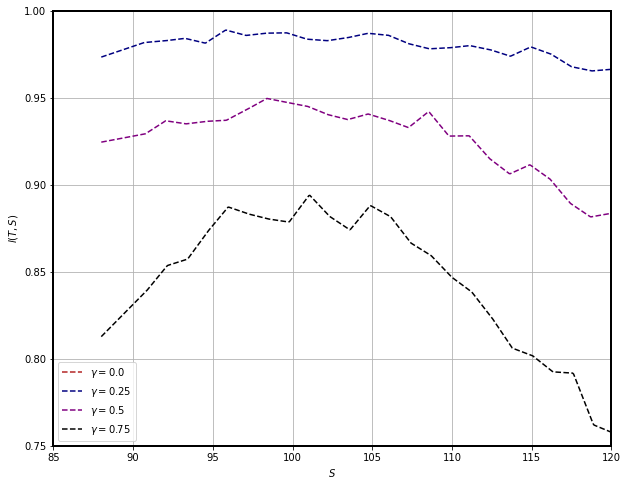

In [809]:
S = np.linspace(88., 120., 500)
colors = ['firebrick', 'navy', 'purple', 'k']
for color, key in zip(colors, results.keys()):
  x, y = results[key]['x_grid'][-1, :], results[key]['leverage'][-1, :]
  f_0 = interp1d(x, y, kind = 'linear', fill_value='extrapolate')
  plt.plot(S, f_0(S), '--', color = color, label = r'$\gamma=' + str(key) + '$')

plt.xlabel(r'$S$')
plt.ylabel(r'$l(T, S)$')
plt.legend()

**Comment:** we can notice that the more $\gamma$ increases the more concave the leverage function becomes

- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the smile on $\gamma$.

In [810]:
N_2 = 100_000
Z = np.random.randn(N_2, n_steps - 1, 2)
rho, kappa = 0., 1.

In [811]:
@jit(nopython = True)
def get_price1(K, gamma, rho, kappa):
  """ Compute the call option price using the model (with leverage function = 1)

      Parameters
      ----------
      K:      scalar
            The strike of the option
      gamma:  scalar
            The volatility of volatility
      rho:    scalar
            The spot-vol correlation coefficient
      kappa:  scalar
            The mean reversion 
      
      Returns
      -------
      m / N_2: scalar
              The estimated price of the option
   """
  m = 0.
  T, s_0, sig_0, y_0, sig_loc = 1., 100., .15, 0., .15
  
  n_steps = 100
  dt = 1. / n_steps

  rho_bar = rho * np.sqrt(2. * (1. - np.exp(-kappa * dt)) / (kappa * dt * (1. + np.exp(-kappa * dt))))

  for j in range(N_2):
    y = y_0
    ls = np.log(s_0)
    for i in range(1, n_steps):
      z_1, z_2 = Z[j, i - 1, :]
      
      ls = ls - .5 * dt * (sig_0 * np.exp(y) )**2  + sig_0 * np.exp(y) * np.sqrt(dt) * (np.sqrt(1 - rho_bar**2) * z_1 + rho_bar * z_2)
      y = y * np.exp(-kappa * dt) + gamma * np.sqrt((1. - np.exp(-2. * kappa * dt)) / (2. * kappa)) * z_2
    
    m += np.maximum(np.exp(ls) - K, 0.) 

  return m / N_2

In [812]:
%%time
Ks = np.linspace(70., 150., 80)
smile = {}
for gamma in gammas:
  smile[str(gamma)] = np.array([implidVolatility(s_0, 0., k, 0., 1., .1, get_price1(k, gamma, rho, kappa), tolerance=1e-10, method = 'Dichotomy') for k in Ks])

Algorithm Converged in :  34  iterations.
Algorithm Converged in :  32  iterations.
Algorithm Converged in :  34  iterations.
Algorithm Converged in :  34  iterations.
Algorithm Converged in :  32  iterations.
Algorithm Converged in :  33  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  36  iterations.
Algorithm Converged in :  31  iterations.
Algorithm Converged in :  34  iterations.
Algorithm Converged in :  36  iterations.
Algorithm Converged in :  36  iterations.
Algorithm Converged in :  36  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  37  iterations.
Algorithm Converged in :  34  iterations.
Algorithm Converged in :  36  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  37  iterations.
Algorithm Converged in :  38  iter

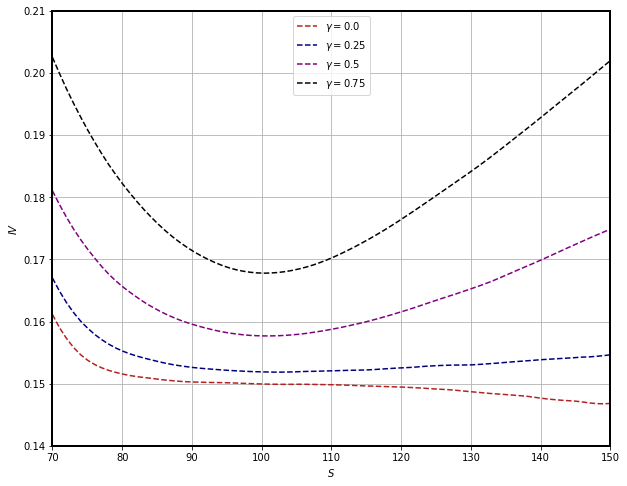

In [813]:
colors = ['firebrick', 'navy', 'purple', 'k']
for color, key in zip(colors, smile.keys()):
  plt.plot(Ks, smile[key], '--', color = color, label = r'$\gamma=' + str(key) + '$')

plt.xlabel(r'$S$')
plt.ylabel(r'$IV$')
plt.legend()

**Comment:** when $\gamma$ is low, the implied volatility smile is relatively flat, with little curvature. As $\gamma$ increases, the smile becomes more pronounced, with higher volatility at both the extreme strikes and at-the-money.

<b>(c).</b> Fix the volatility of volatility $\gamma = 50\%$ and mean reversion $\kappa=1$. We study the impact of spot-vol correlation $\rho$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\rho$. Suggested values of $\rho$: $-50\%$, $0\%$, $50\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\rho$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\rho$ in the same graph. Comment on the dependence of the shape of the leverage function on $\rho$.

In [814]:
# Different values spot-vol correlation rho
rhos = [-0.5, -0.2, 0., 0.2, 0.5]

In [815]:
def leverage_Rho(rhos, gamma = .5, kappa = 1.):
  """ Calibrate leverage function for different 
      values of the spot-vol correlation

      Paramaters
      ----------
      rhos:   list of scalar
            The different values of spot-vol correlation 
      gammas: scalar
            The volatility of volatility
      
      kappa:  scalar
            The mean reversion

      Returns
      -------
      results1: dict
               Contains two keys, x_grid and leverage
   """


  N_1 = 10_000
  results1 = {}

  for rho in rhos:
    leverage, x_grid = calib_lever(gamma, rho, kappa, N_1)
    
    results1[str(rho)] = {'x_grid': x_grid, 'leverage': leverage}
  return results1

In [816]:
results1 = leverage_Rho(rhos)

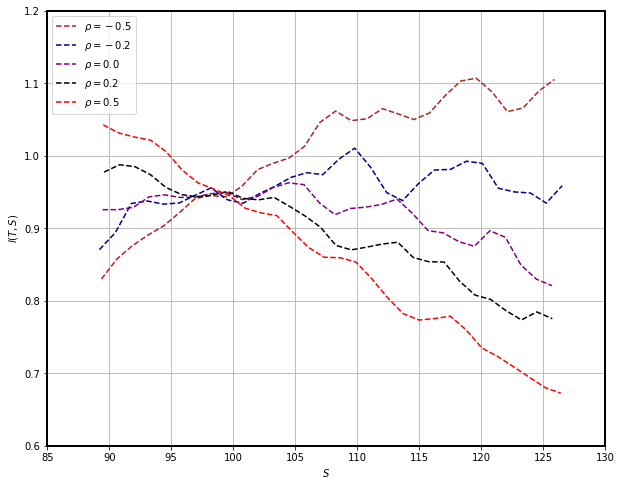

In [817]:
S = np.linspace(70., 150., 500)
colors = ['firebrick', 'navy', 'purple', 'k', 'red']
for color, key in zip(colors, results1.keys()):
  x, y = results1[key]['x_grid'][-1, :], results1[key]['leverage'][-1, :]
  f_0 = interp1d(x, y, kind = 'linear', fill_value='extrapolate')
  plt.plot(x, y, '--', color = color, label = r'$\rho=' + str(key) + '$')

plt.xlabel(r'$S$')
plt.ylabel(r'$l(T, S)$')
plt.legend()

**Comment:** the sign of $\rho$ is the opposite sign of the slope of the leverage function, so that the more the values of $\rho$ increases the more the leverage function slopes

- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\rho$ in the same graph. Comment on the dependence of the shape of the smile on $\rho$.

In [818]:
N_2 = 10_000
Z = np.random.randn(N_2, n_steps - 1, 2)
gamma, kappa = .5, 1.

In [819]:
%%time
Ks = np.linspace(80., 150., 80)
smileR = {}
for rho in rhos:
  smileR[str(rho)] = np.array([implidVolatility(s_0, 0., k, 0., 1., .1, get_price1(k, gamma, rho, kappa), method = 'Dichotomy') for k in Ks])

Algorithm Converged in :  20  iterations.
Algorithm Converged in :  15  iterations.
Algorithm Converged in :  19  iterations.
Algorithm Converged in :  17  iterations.
Algorithm Converged in :  20  iterations.
Algorithm Converged in :  20  iterations.
Algorithm Converged in :  20  iterations.
Algorithm Converged in :  20  iterations.
Algorithm Converged in :  21  iterations.
Algorithm Converged in :  20  iterations.
Algorithm Converged in :  21  iterations.
Algorithm Converged in :  19  iterations.
Algorithm Converged in :  19  iterations.
Algorithm Converged in :  19  iterations.
Algorithm Converged in :  21  iterations.
Algorithm Converged in :  20  iterations.
Algorithm Converged in :  21  iterations.
Algorithm Converged in :  17  iterations.
Algorithm Converged in :  19  iterations.
Algorithm Converged in :  20  iterations.
Algorithm Converged in :  21  iterations.
Algorithm Converged in :  21  iterations.
Algorithm Converged in :  21  iterations.
Algorithm Converged in :  19  iter

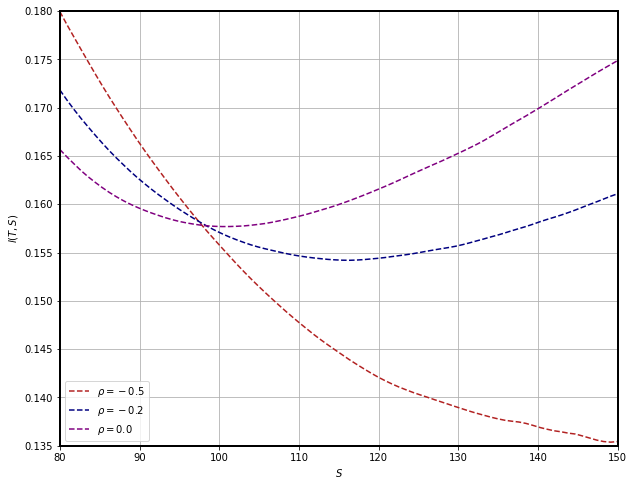

In [820]:
colors = ['firebrick', 'navy', 'purple']
for color, key in zip(colors, smileR.keys()):
  plt.plot(Ks, smileR[key], '--', color = color, label = r'$\rho=' + str(key) + '$')

plt.xlabel(r'$S$')
plt.ylabel(r'$l(T, S)$')
plt.legend()

**Comment:** When $\rho$ is negative the implied volatility smile ends to be negatively skewed. When $\rho$ is positive the implied volatility smile tends to be positively skewed

<b>(d).</b> Fix the spot-vol correlation $\rho = 0\%$ and volatility of volatility $\gamma = 50\%$. We study the impact of mean reversion $\kappa$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\kappa$. Suggested values of $\kappa$: $0.1$, $1$, $10$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\kappa$.

In [821]:
# Different values of mean reversion kappa
kappas = [0.1, 1., 10.]

In [822]:
def leverage_Kappa(kappas, rho = 0., gamma = .5):
  """ Calibrate leverage function for different 
      values of the spot-vol correlation

      Paramaters
      ----------
      kappa:  list of scalar
            The different values of mean reversion
      rho:   scalar
            The spot-vol correlation 
      gammas: scalar
            The volatility of volatility
      
      Returns
      -------
      results2: dict
               Contains two keys, x_grid and leverage
  """
  results2 = {}
  rho, gamma = 0., .5

  N_1 = 10_000

  for kappa in kappas:
    leverage, x_grid = calib_lever(gamma, rho, kappa, N_1)
    
    results2[str(kappa)] = {'x_grid': x_grid, 'leverage': leverage}
  return results2

In [823]:
results2 = leverage_Kappa(kappas)

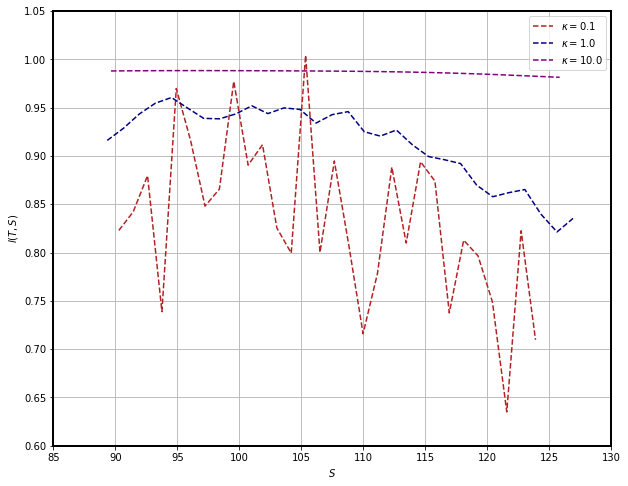

In [824]:
S = np.linspace(70., 150., 500)
colors = ['firebrick', 'navy', 'purple']
for color, key in zip(colors, results2.keys()):
  x, y = results2[key]['x_grid'][-1, :], results2[key]['leverage'][-1, :]
  #f_0 = interp1d(x, y, kind = 'linear', fill_value='extrapolate')
  plt.plot(x, y, '--', color = color, label = r'$\kappa=' + str(key) + '$')

plt.xlabel(r'$S$')
plt.ylabel(r'$l(T, S)$')
plt.legend()

**Comment:** the shape of the leverage function is flatter for larger mean-reversion parameters and steeper for smaller mean-reversion parameters.


- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\kappa$ in the same graph. Comment on the dependence of the shape of the smile on $\kappa$.

In [825]:
N_2 = 100_000
Z = np.random.randn(N_2, n_steps - 1, 2)
gamma, rho = .5, 0.

In [826]:
%%time
Ks = np.linspace(70., 150., 100)
smileK = {}
for kappa in kappas:
  smileK[str(kappa)] = np.array([implidVolatility(s_0, 0., k, 0., 1., .1, get_price1(k, gamma, rho, kappa), tolerance=1e-10, method = 'Dichotomy') for k in Ks])

Algorithm Converged in :  35  iterations.
Algorithm Converged in :  34  iterations.
Algorithm Converged in :  33  iterations.
Algorithm Converged in :  34  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  34  iterations.
Algorithm Converged in :  36  iterations.
Algorithm Converged in :  36  iterations.
Algorithm Converged in :  36  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  36  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  32  iterations.
Algorithm Converged in :  35  iterations.
Algorithm Converged in :  37  iterations.
Algorithm Converged in :  37  iterations.
Algorithm Converged in :  36  iterations.
Algorithm Converged in :  37  iterations.
Algorithm Converged in :  37  iterations.
Algorithm Converged in :  37  iterations.
Algorithm Converged in :  36  iter

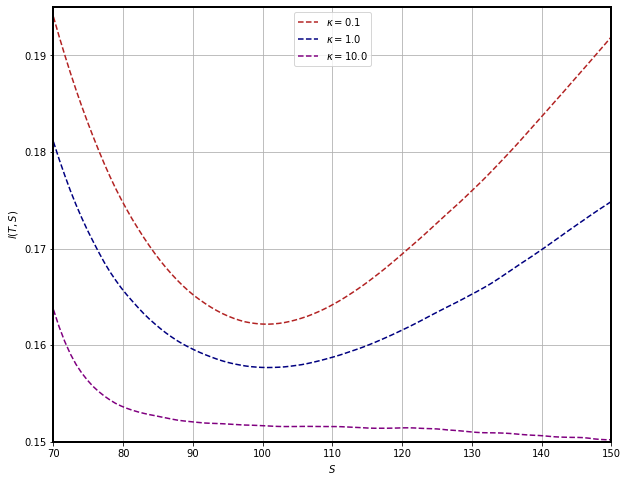

In [827]:
colors = ['firebrick', 'navy', 'purple']
for color, key in zip(colors, smileK.keys()):
  plt.plot(Ks, smileK[key], '--', color = color, label = r'$\kappa=' + str(key) + '$')

plt.xlabel(r'$S$')
plt.ylabel(r'$l(T, S)$')
plt.legend()

**Comment:** when $\kappa$ is low, the implied volatility smile is pronounced, with high volatility at both the extreme strikes and at-the-money. When $\kappa$ increases, the smile becomes less pronounced, with lower volatility at both the tails and at-the-money.

<b>(e).</b> Consider the forward-starting call spread with payoff
\begin{equation*}
\left( \frac{S_{T_2}}{S_{T_1}}-0.95 \right)_+ - \left( \frac{S_{T_2}}{S_{T_1}}-1.05 \right)_+
\end{equation*}
with $T_1 = T - \frac{3}{12}$, $T_2 = T$. Use $\gamma = 100\%$, $\rho = -50\%$ and $\kappa=1$. Compare the prices of this option in the Black-Scholes model with volatility 15% and in the calibrated SLV model. Comment on the result. Why is it of interest to use stochastic local volatility models for pricing derivatives?

In [828]:
T, s_0, sig_0, y_0, rho, gamma, kappa = 1., 100., .15, 0., -0.5, 1., 1.
T1, T2 = T - 3/12, T

The price (at t = 0) in the Black-Scholes model of the call option with the following payoff  $\left( \frac{S_{T_2}}{S_{T_1}}-0.95 \right)_+$ is
$$P_{BS} = \mathbb{E}\left(\exp\left(- \frac{\sigma^2}{2}(T_2-T_1)+\sigma \sqrt{T_2-T_1}Z\right)-0.95\right)_+ = C_{BS}(1, 0.95, T_2-T_1, \sigma)$$
It follows that the BS price (at t = 0) of the forward-starting call spread with payoff $\left( \frac{S_{T_2}}{S_{T_1}}-0.95 \right)_+ - \left( \frac{S_{T_2}}{S_{T_1}}-1.05 \right)_+$ is
$$C_{BS}(1,0.95,T_2-T_1,\sigma)-C_{BS}(1,1.05,Tt_2-T_1,\sigma)$$

In [829]:
# BS price
PriceBS(1., 0., 0.95, 0., T2 - T1, 0.15) - PriceBS(1., 0., 1.05, 0., T2 - T1, 0.15 )

0.04880425501889846

In [830]:
N_2 = 5_000
Z = np.random.randn(N_2, n_steps - 1, 2)

In [831]:
rho, gamma, kappa = -.5, 1., 1.
N_1 = 10_000
leverage, x_grid = calib_lever(gamma, rho, kappa, N_1)

In [832]:
def get_priceE(leverage, x_grid):

  """ Compute the forward-starting call spread price with the calibrated model 
      
      Returns
      -------
      m / N_2: scalar
               The estimated price of the forward-starting call spread 
  """
  m = 0.

  T, s_0, sig_0, y_0, rho, gamma, kappa = 1., 100., .15, 0., -0.5, 1., 1.
  n_steps = 100
  dt = 1. / n_steps
  rho_bar = rho * np.sqrt(2. * (1. - np.exp(-kappa * dt)) / (kappa * dt * (1. + np.exp(-kappa * dt))))
  
  for j in range(N_2):
    y = y_0
    ls = np.log(s_0)
    ls1 = []
    for i in range(1, n_steps):
      z_1, z_2 = Z[j, i - 1, :]

      if i == 1:
         lev_inter = lambda x: leverage[0, 0]
      else:
         lev_inter = interp1d(x_grid[i - 1, :], leverage[i - 1, :], kind='linear', fill_value='extrapolate')
      
      ls = ls - .5 * dt * (sig_0 * np.exp(y) * lev_inter(np.exp(ls)))**2  + sig_0 * np.exp(y) * lev_inter(np.exp(ls)) * np.sqrt(dt) * (np.sqrt(1 - rho_bar**2) * z_1 + rho_bar * z_2)
      y = y * np.exp(-kappa * dt) + gamma * np.sqrt((1. - np.exp(-2. * kappa * dt)) / (2. * kappa)) * z_2
      if i == 75:
        ls1.append(ls)
    m += np.maximum((np.exp(ls) / np.exp(ls1)) - 0.95, 0.) - np.maximum((np.exp(ls) / np.exp(ls1)) - 1.05, 0.)

  return m / N_2

In [833]:
get_priceE(leverage, x_grid)

array([0.05048836])

**Comment:** The computed price with the calibrated model is slightly higher then the one with BS.

- SLV models allow for flexible modeling of volatility surfaces by allowing for both stochastic volatility and local volatility components
- SLV models can capture the observed volatility smiles and skews, which are not captured by more traditional models like Black-Scholes.